<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/CVNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1 = timer()
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  import os, requests, torch
  from pathlib import Path
  from torch import nn, optim
  from torch.utils.data import DataLoader
  from torch.nn import CrossEntropyLoss
  from torchvision import datasets, transforms
  import matplotlib.pyplot as plt
  import numpy as np
  print(f">>>> You are on CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload")

def __tmfmt__(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h}, mins: {m:>02}, secs: {s:>05.2f}"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 256 if device == torch.device("cuda") else 32

print(f">>>> Available device: {device}\n")
!nvidia-smi
print(f">>>> Time elapsed:\t{__tmfmt__(timer() - t1)}")

  

Mounted at /content/drive/
>>>> You are on CoLaB with torch version: 1.13.1+cu116
>>>> Available device: cuda

Sat Feb 11 19:41:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [ ]:
train_data = datasets.FashionMNIST(root = "train_data/",
                                   train = True,
                                   download = True,
                                   transform = transforms.ToTensor())
test_data = datasets.FashionMNIST(root = "test_data/",
                                  train = False,
                                  download = True,
                                  transform = transforms.ToTensor())
class_labels = train_data.targets
classess = train_data.classes
class_to_idx = train_data.class_to_idx
print(f">>>> Class labels:\n {class_labels}\n>>>> Classes available:\n {classess}\n>>>> Class dictionary:\n {class_to_idx}")

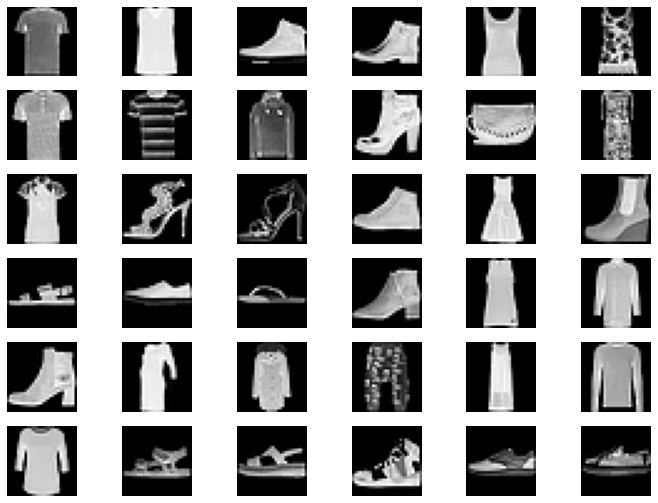

In [3]:
fig = plt.figure(figsize = (12, 9))
rows, cols = 6, 6
for k in range(1, rows * cols + 1):
  idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data.data[idx], train_data.targets[idx]
  fig.add_subplot(rows, cols, k)
  plt.imshow(img.squeeze().numpy(), cmap = "gray")
  plt.axis("off")


In [4]:
train_loader, test_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last= True),\
                             DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

xtrain_batch, ytrain_batch = next(iter(train_loader))
xtest_batch, ytest_batch = next(iter(test_loader))
assert xtrain_batch.shape == xtest_batch.shape
assert ytrain_batch.shape == ytest_batch.shape 

In [5]:
def __plotDecisionBoundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor):

  # transfers from the GPU to CPU for plotting
  model, X, y = model.to(device), X.to(device), y.to(device)

  # Set the axes boundaries
  xx_min, xx_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  xy_min, xy_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

  # Get the data to plot
  xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 101), np.linspace(xy_min, xy_max, 101))

  # stacking the vectors together

  xx_data = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Obtain the model's output for plotting the decision
  model.eval()
  with torch.inference_mode():
    logits = model(xx_data)
  
  if len(y.unique()) > 2: # For multiclass problems
    preds = torch.softmax(logits, dim = 1).argmax(dim = 1)
  else: # For binary problems
    preds = torch.round(torch.sigmoid(logits))

  # Convering the predictions into np.ndarray

  preds = preds.reshape(xx.shape).detach().numpy()
  
  # Plotting the decission boundary
  plt.figure(figsize = (15, 15))
  plt.contourf(xx, yy, preds, alpha = 0.7, cmap = plt.cm.RdYlBu)
  plt.scatter(X[:, 0], X[:, 1], s = 23, c = "red", cmap = plt.cm.RdYlBu)
  plt.xlim(xx_min, xx_max)
  plt.ylim(xy_min, xy_max)
  plt.title("The decision boundary for the classifier")
  




In [6]:
# Defining the accuracy function
def accuracyScore(logits: torch.Tensor, labels: torch.Tensor)->torch.float32:
  if len(labels.unique()) > 2:
    preds = torch.softmax(logits, dim = 1).argmax(dim = 1)
  else:
    preds = torch.round(torch.sigmoid(logits))
  
  acc = torch.eq(preds, labels).sum().item()

  acc/= len(labels)
  
  return f"{acc*100:.2f}"



In [8]:
# Model class
class MLP_classifier(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(MLP_classifier, self).__init__()
    self.in_dim, self.out_dim = in_dim, out_dim
    self.mlp = nn.Sequential(
        nn.Linear(self.in_dim, 128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features = 128),
        nn.Dropout(p = 0.45),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(num_features = 64),
        nn.Linear(64, self.out_dim)
    )
  
  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.mlp(x)

class CV_classifier(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(CV_classifier, self).__init__()
    self.in_channels, self.num_classes = in_channels,num_classes
    self.cv1 = nn.Conv2d(in_channels = self.in_channels,
                         out_channels = 8,
                         kernel_size = 5)
    self.act = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(num_features = 8)
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.cv2 = nn.Conv2d(in_channels = 8,
                         out_channels = 32,
                         kernel_size = 5)
    self.bn2 = nn.BatchNorm2d(num_features = 32)
    self.flatten = nn.Flatten()
    self.mlp = nn.Sequential(
        nn.Linear(in_features = 32 * 4 * 4, out_features = 128),
        nn.ReLU(),
        nn.BatchNorm1d(num_features = 128),
        nn.Dropout(p = 0.5),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(num_features = 64),
        nn.Linear(64, self.num_classes)
    )
  
  def forward(self, x: torch.Tensor)->torch.Tensor:
    x = self.maxpool(self.bn1(self.act(self.cv1(x))))
    x = self.maxpool(self.bn2(self.act(self.cv2(x))))
    x = self.flatten(x)
    out = self.mlp(x)
    return out

in_dim, out_dim, in_channels = 28 * 28 * 1, 10, 1
model1 = MLP_classifier(in_dim, out_dim).to(device = device)
model2 = CV_classifier(in_channels, out_dim).to(device = device)
assert model1(xtrain_batch.view(BATCH_SIZE,-1).to(device)).shape == (BATCH_SIZE, out_dim)
assert model2(xtrain_batch.to(device)).shape == (BATCH_SIZE, out_dim)

print(f">>>> Model1 architecture: \n{model1}\n>>>> Model2 architecture:\n {model2}")


>>>> Model1 architecture: 
MLP_classifier(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.45, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)
>>>> Model2 architecture:
 CV_classifier(
  (cv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (act): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Seq

In [9]:
criterion = CrossEntropyLoss(reduction = "mean")
EPOCHS = 100
learning_rate = 1e-3
optimizer1 = optim.Adam(params = model1.parameters(), lr = learning_rate)
optimizer2 = optim.Adam(params = model2.parameters(), lr = learning_rate)



In [10]:
def train_test_loop(model, train_loader, test_loader, optimizer, criterion, EPOCHS):

  model.train()
  for epoch in range(EPOCHS):
    train_loss = 0
    num_samples = 0
    eval_loss = 0
    for idx, (data, labels) in enumerate(train_loader):
      data, labels = data.to(device = device), labels.to(device = device)
      if model == model1:
        data = data.view(BATCH_SIZE, -1)
      else:
        data = data
      
      optimizer.zero_grad()
      logits = model(data)
      tr_loss = criterion(logits, labels)
      tr_loss.backward()
      optimizer.step()
      train_loss+= tr_loss
      num_samples+=idx

    if epoch % 10 == 0:
      print(f"\n>>>> End of training for epoch: {(epoch + 1) if epoch == 0 else epoch}\t\
      |\t Train loss: {train_loss/num_samples:.4f}\t|\tTrain accuracy: {accuracyScore(logits, labels)} %")

    model.eval()
    with torch.inference_mode():
      for idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device = device), labels.to(device = device)
        #print(f">>>> xtest_batch shape: {data.shape}, xtest_batch reshaped: {data.view(BATCH_SIZE, -1).shape}")
        logits = model(data.view(BATCH_SIZE,-1)) if model == model1 else model(data)
        ev_loss = criterion(logits, labels)
        eval_loss+= ev_loss
        num_samples+= idx

    if epoch % 10 == 0:
      print(f">>>> End of validation for epoch: {(epoch + 1) if epoch == 0 else epoch}\t\
      |\t Validation loss: {eval_loss/num_samples:.4f}\t|\tValidation accuracy: {accuracyScore(logits, labels)} %")
    


In [11]:
tic = timer()
print(f">>>> Starting experiment on MLP_classifier for {EPOCHS} epochs: Please wait.........................................................\n")
train_test_loop(model1, train_loader, test_loader, optimizer1, criterion, EPOCHS)
print(f"\n>>>> End of experiment on MLP_classifier for {EPOCHS} epochs:\n")
print(f">>>> Starting experiment on CNN classifier for {EPOCHS} epochs: Please wait..........................................................\n")
train_test_loop(model2, train_loader, test_loader, optimizer2, criterion, EPOCHS)
print(f"\n>>>> End of experimentantion on CNN classifier for {EPOCHS} epochs")
toc = timer()
print(f">>>> Total time elapsed: {__tmfmt__(toc - tic)}")


>>>> Starting experiment on MLP_classifier for 100 epochs: Please wait.........................................................


>>>> End of training for epoch: 1	      |	 Train loss: 0.0053	|	Train accuracy: 87.89 %
>>>> End of validation for epoch: 1	      |	 Validation loss: 0.0006	|	Validation accuracy: 86.33 %

>>>> End of training for epoch: 10	      |	 Train loss: 0.0020	|	Train accuracy: 90.62 %
>>>> End of validation for epoch: 10	      |	 Validation loss: 0.0005	|	Validation accuracy: 89.45 %

>>>> End of training for epoch: 20	      |	 Train loss: 0.0015	|	Train accuracy: 91.02 %
>>>> End of validation for epoch: 20	      |	 Validation loss: 0.0005	|	Validation accuracy: 86.72 %

>>>> End of training for epoch: 30	      |	 Train loss: 0.0012	|	Train accuracy: 94.92 %
>>>> End of validation for epoch: 30	      |	 Validation loss: 0.0006	|	Validation accuracy: 89.45 %

>>>> End of training for epoch: 40	      |	 Train loss: 0.0010	|	Train accuracy: 93.75 %
>>>> End of validat